In [1]:
import csv
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
random.seed(27)
sns.set()

In [3]:
def convert_windows_path_to_relative_linux(windows_path):
    filename = windows_path.split("\\")[-1]
    linux_path = 'data/IMG/' + filename
    
    return linux_path

def preprocess_image(image):
    # Removes portions of the image that doesn't have relevant information of the track
    image = image[64:140, 0:320, :]

    return image

def read_image(filepath, preprocess=True):
    image = cv2.imread(filepath)
    
    if preprocess:
        image = preprocess_image(image)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return image

## Offsets
Below is defined the offsets to apply on left and right camera steering angles. For details on why a offset is applied, take a look in `writeup_report.md` file

In [4]:
offset_left_camera = 0.2
offset_right_camera = -0.2

## Loading data
Cell used to load data from `data/` folder, and adding offsets to steering angles of left and right camera.

In [5]:
lines = []
with open("data/driving_log.csv") as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        lines.append(line)
        
images = []
steers = []
for line in lines:
    for i in range(3):
        filepath = convert_windows_path_to_relative_linux(line[i])
        image = read_image(filepath)
        
        # center
        if i == 0:
            steer = float(line[3])
            steers.append(steer)
            images.append(image)
        # left
        elif i == 1:
            steer = float(line[3])
            steers.append(steer + offset_left_camera)
            images.append(image)
        # right
        elif i == 2:
            steer = float(line[3])
            steers.append(steer - offset_right_camera)
            images.append(image)

## Data exploration

Taking a look on how images from the dataset looks like after removing parts of the image that doesn't have useful information to drive, and applying offsets to left and right camera images.

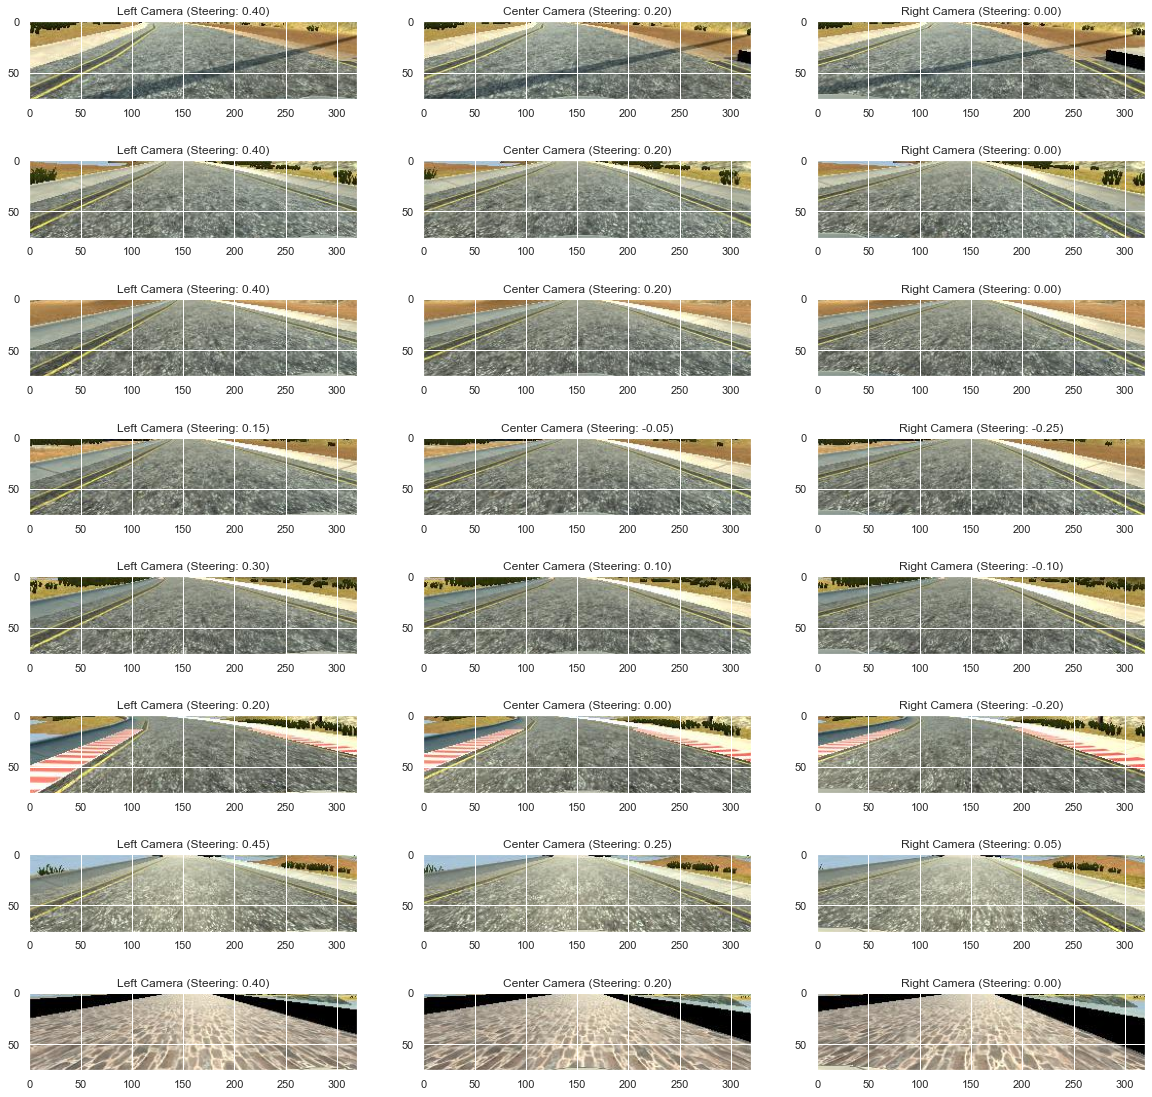

In [6]:
indexes = [100, 200, 350, 400, 500, 600, 725, 815]
fig, axes = plt.subplots(len(indexes), 3, figsize=(20, 20))

for i in range(len(indexes)):
    idx = indexes[i]
    
    filepath_l = convert_windows_path_to_relative_linux(lines[idx][1])
    image_l = read_image(filepath_l)
    
    filepath_c = convert_windows_path_to_relative_linux(lines[idx][0])
    image_c = read_image(filepath_c)
    
    filepath_r = convert_windows_path_to_relative_linux(lines[idx][2])
    image_r = read_image(filepath_r)

    axes[i, 0].set_title("Left Camera (Steering: {:.2f})".format(steers[idx] + offset_left_camera))
    axes[i, 0].imshow(image_l)
    axes[i, 1].set_title("Center Camera (Steering: {:.2f})".format(steers[idx]))
    axes[i, 1].imshow(image_c)
    axes[i, 2].set_title("Right Camera (Steering: {:.2f})".format(steers[idx] + offset_right_camera))
    axes[i, 2].imshow(image_r)
plt.show()

In [7]:
unique, counts = np.unique(np.array(steers), return_counts=True)

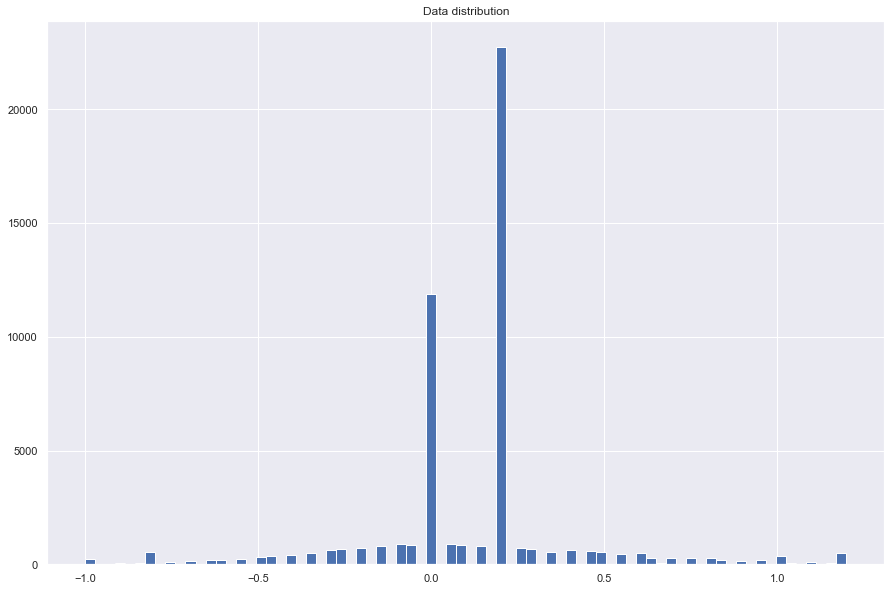

In [8]:
fig = plt.figure(figsize=(15,10))
plt.title("Data distribution")
plt.hist(steers, bins=len(unique))
plt.show()

In [9]:
steerings = {}
for i in range(len(unique)):
    steerings[unique[i]] = counts[i]
freq = {k: v for k, v in sorted(steerings.items(), key=lambda item: item[1])}
freq = pd.DataFrame(freq.items(), columns=['steering', 'count'])
freq = freq.sort_values(by=['count'], ascending=False)
freq.head(10)

,steering,count
75,0.20,22752
74,0.00,11863
73,0.10,869
72,-0.20,730
71,0.25,722
70,-0.25,668
69,0.05,630
68,0.40,623
67,0.15,602
66,0.45,596


## Data augmentation
Augmentating the dataset flipping images and inverting the corresponding steering angle. By doing this we have more images to train the algorithm and also solves the problem of having too much examples turning to the right (as we can see above).

In [10]:
augmented_images, augmented_steers = [], []

for image, steer in zip(images, steers):
    augmented_images.append(image)
    augmented_steers.append(steer)
    augmented_images.append(cv2.flip(image, 1))
    augmented_steers.append(steer*-1.0)

In [11]:
unique, counts = np.unique(np.array(augmented_steers), return_counts=True)

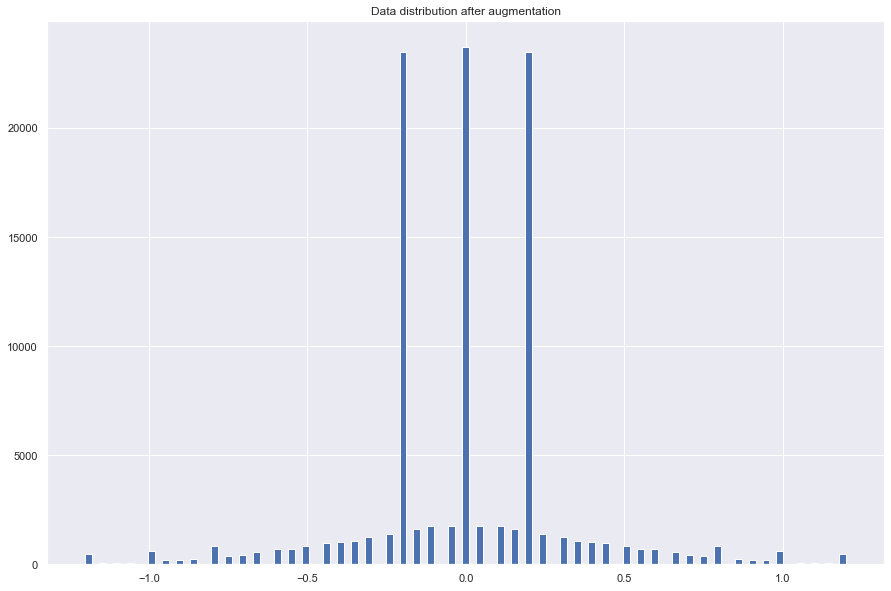

In [12]:
fig = plt.figure(figsize=(15, 10))
plt.title("Data distribution after augmentation")
plt.hist(augmented_steers, bins=len(unique))
plt.show()

In [13]:
augmented_images, augmented_steers = shuffle(augmented_images, augmented_steers, random_state=27)
X_train, X_val, y_train, y_val = train_test_split(augmented_images,
                                                  augmented_steers,
                                                  test_size=0.2,
                                                  random_state=27)

In [14]:
np.save("X_train", X_train)
np.save("y_train", y_train)
np.save("X_val", X_val)
np.save("y_val", y_val)